# Trading strategy exploration and backtesting project with Python 3 

##  Load data 

In [15]:
import sys
import numpy as np
import pandas as pd

!{sys.executable} -m pip install --user matplotlib
import matplotlib.pyplot as plt

!{sys.executable} -m pip install --user seaborn
import seaborn as sns
#%matplotlib inline

In [86]:
file_path = sys.path[0]
file_path

'/Users/liaobofei/Desktop/trading-strategy-explorer'

In [87]:
PATH_QQQ = "/data/QQQ.csv"
PATH_EOSBTC1d = "/data/EOSBTC_1d.csv"

df = pd.read_csv(file_path+PATH_QQQ,
                     index_col=0, 
                     parse_dates=True,)

/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_25366/454246999.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path+PATH_QQQ,



## Exploratory analysis 

In [88]:
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2024-04-29,432.75,30022160,433.13,433.76,429.9800
2024-04-26,431.00,41874910,427.62,432.55,426.9200
2024-04-25,424.45,57392170,419.24,425.32,418.1400
2024-04-24,426.51,48440310,428.20,429.73,424.2000
2024-04-23,425.07,44384740,420.77,426.28,418.8715


In [89]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,21.0,4.330224e+02,8.876380e+00,414.65,425.84,432.75,440.60,445.37
Volume,21.0,4.871021e+07,1.117164e+07,28144940.00,41874910.00,47618960.00,56880540.00,75230990.00
Open,21.0,4.338519e+02,8.922144e+00,417.31,427.62,436.78,441.10,446.33
High,21.0,4.364510e+02,8.413083e+00,421.18,429.73,439.24,443.17,447.53
Low,21.0,4.300758e+02,8.931619e+00,413.07,424.20,430.21,437.44,443.02


In [90]:
cols = [i for i in list(df.columns)] # show me all the columns
print(cols)

['Close', 'Volume', 'Open', 'High', 'Low']


In [91]:
df.isna().sum() 

Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64


## QQQ Data Preprocessing

In [92]:
def QQQpreprocessing(df):
    df2 = df.copy()
    #We have daily candle, so we can remove, hours, minutes and seconds from our data
    #df2['Date']=df2['Date'].apply(lambda x: str(x).replace('00:00:00',''))
    #df2 = df2.set_index('Date')
    df2 = df2.sort_values(['Date']) # sort by date
    df3 = df2.copy()
    return df3


In [93]:
df_price = QQQpreprocessing(df)

#df_price = df.copy() # OR

df_price.head(5)
df_price.tail(5)

,Close,Volume,Open,High,Low
Date,,,,,
2024-04-23,425.07,44384740,420.77,426.28,418.8715
2024-04-24,426.51,48440310,428.20,429.73,424.2000
2024-04-25,424.45,57392170,419.24,425.32,418.1400
2024-04-26,431.00,41874910,427.62,432.55,426.9200
2024-04-29,432.75,30022160,433.13,433.76,429.9800


My first value is the last one in time order, so I have to reorder my dataset.


## Plot data

In [94]:
import matplotlib.ticker as ticker
def plot_time_series(df, Y):
    sns.set_theme(style="darkgrid")
    sns.set(rc={"figure.figsize":(25, 20)})
    # build the figure
    fig, ax = plt.subplots()
    sns.lineplot(data=df, x=df.index , y=Y)
    
    # assign locator and formatter for the xaxis ticks.
    tick_spacing=20
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    plt.show()


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


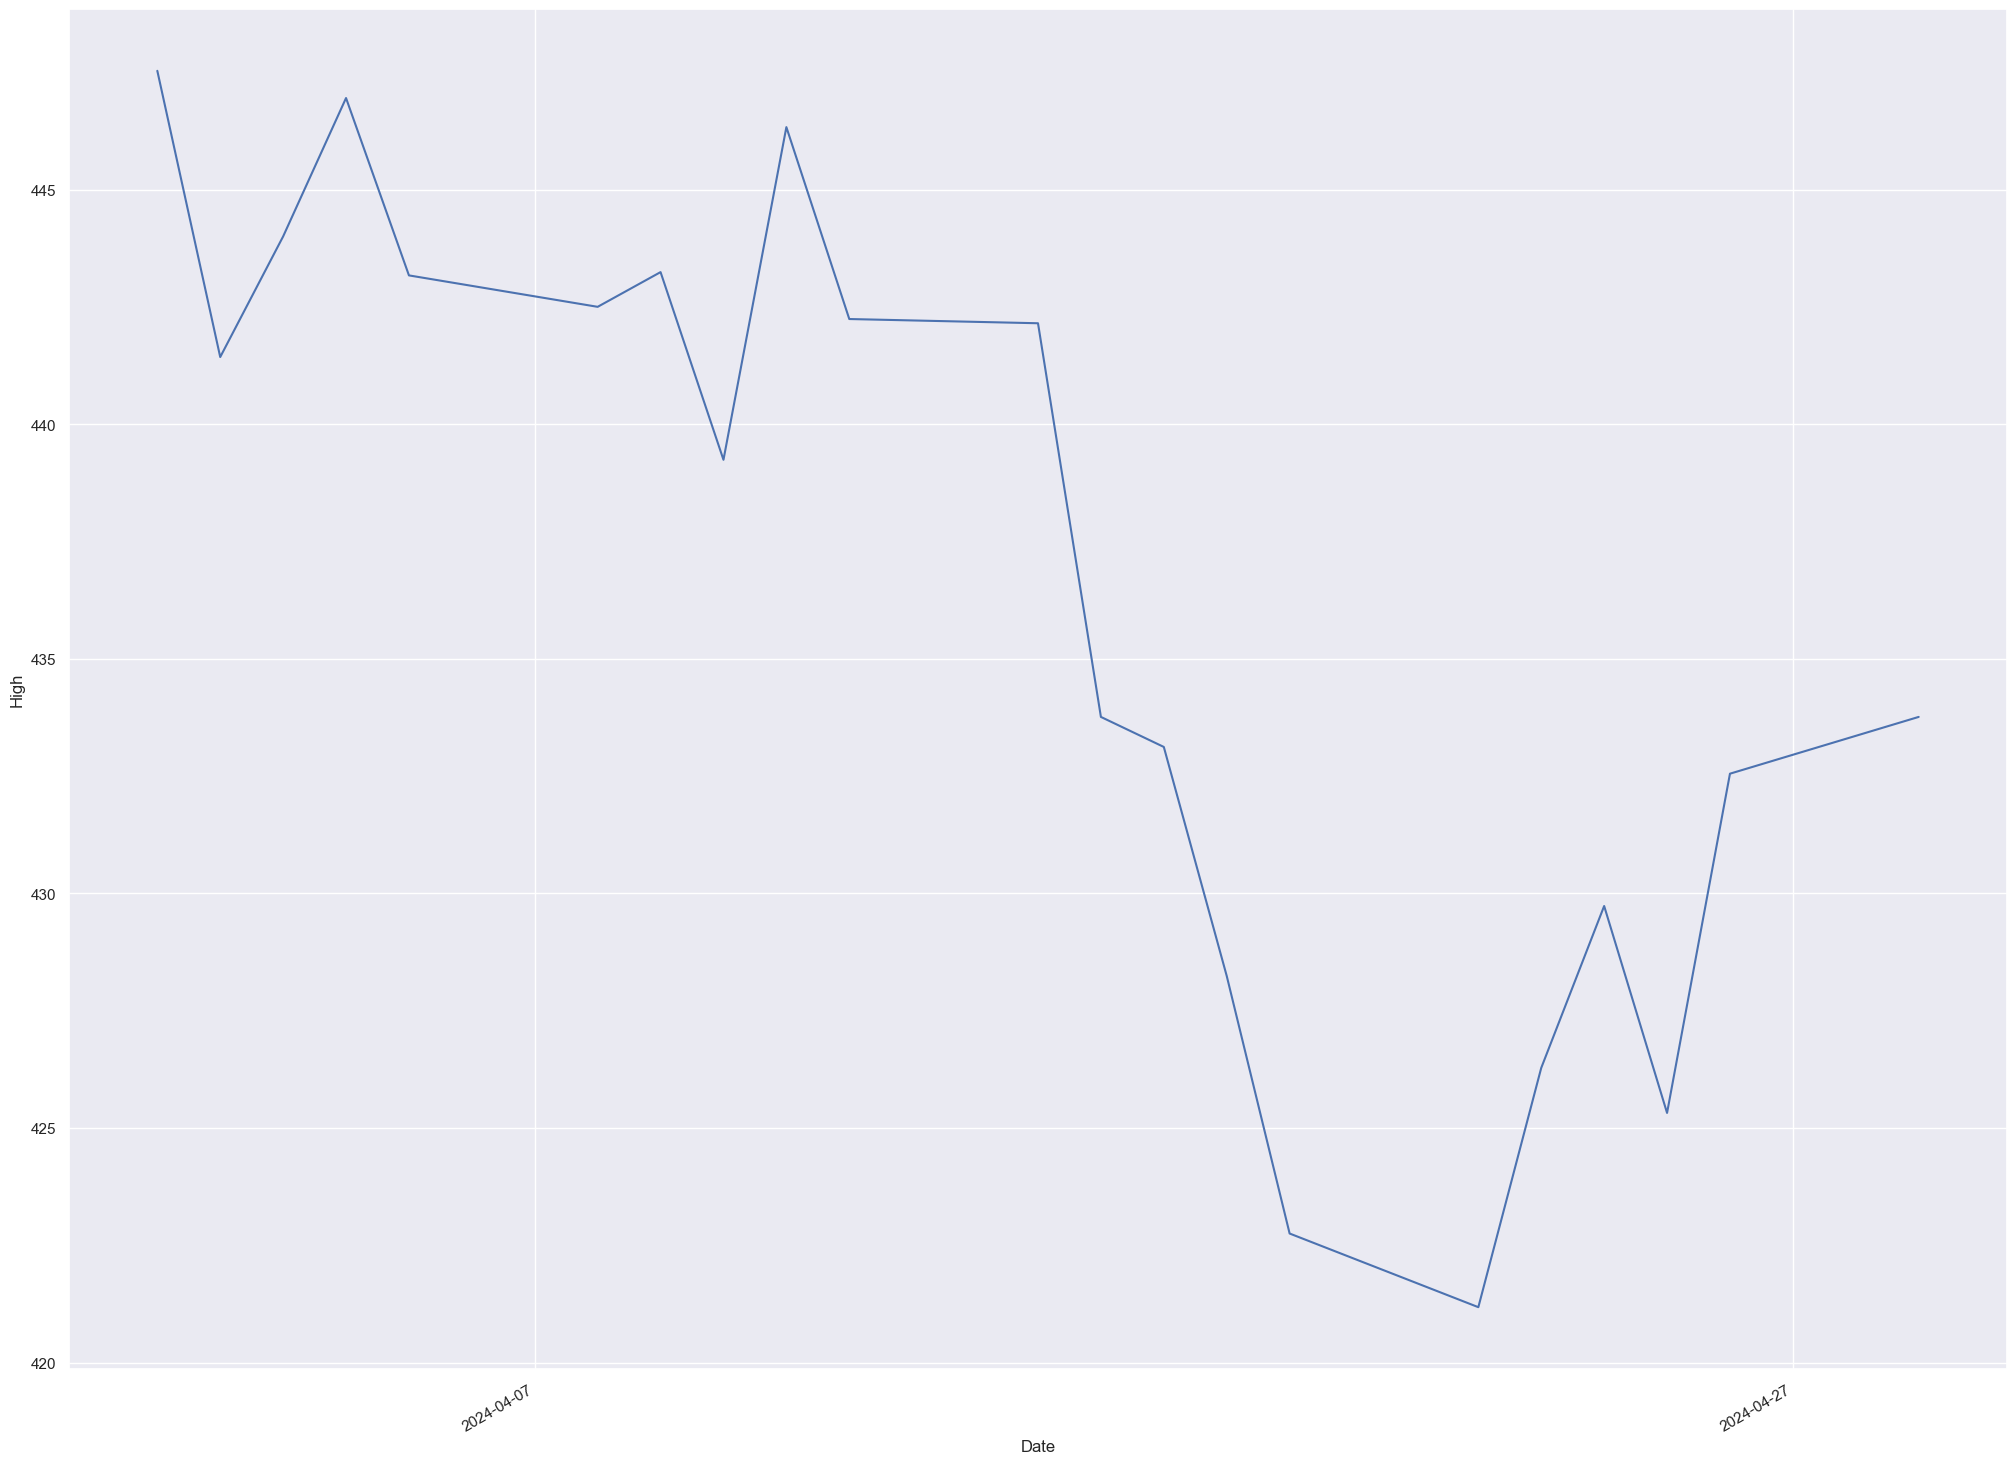

In [95]:
plot_time_series(df_price,'High')

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


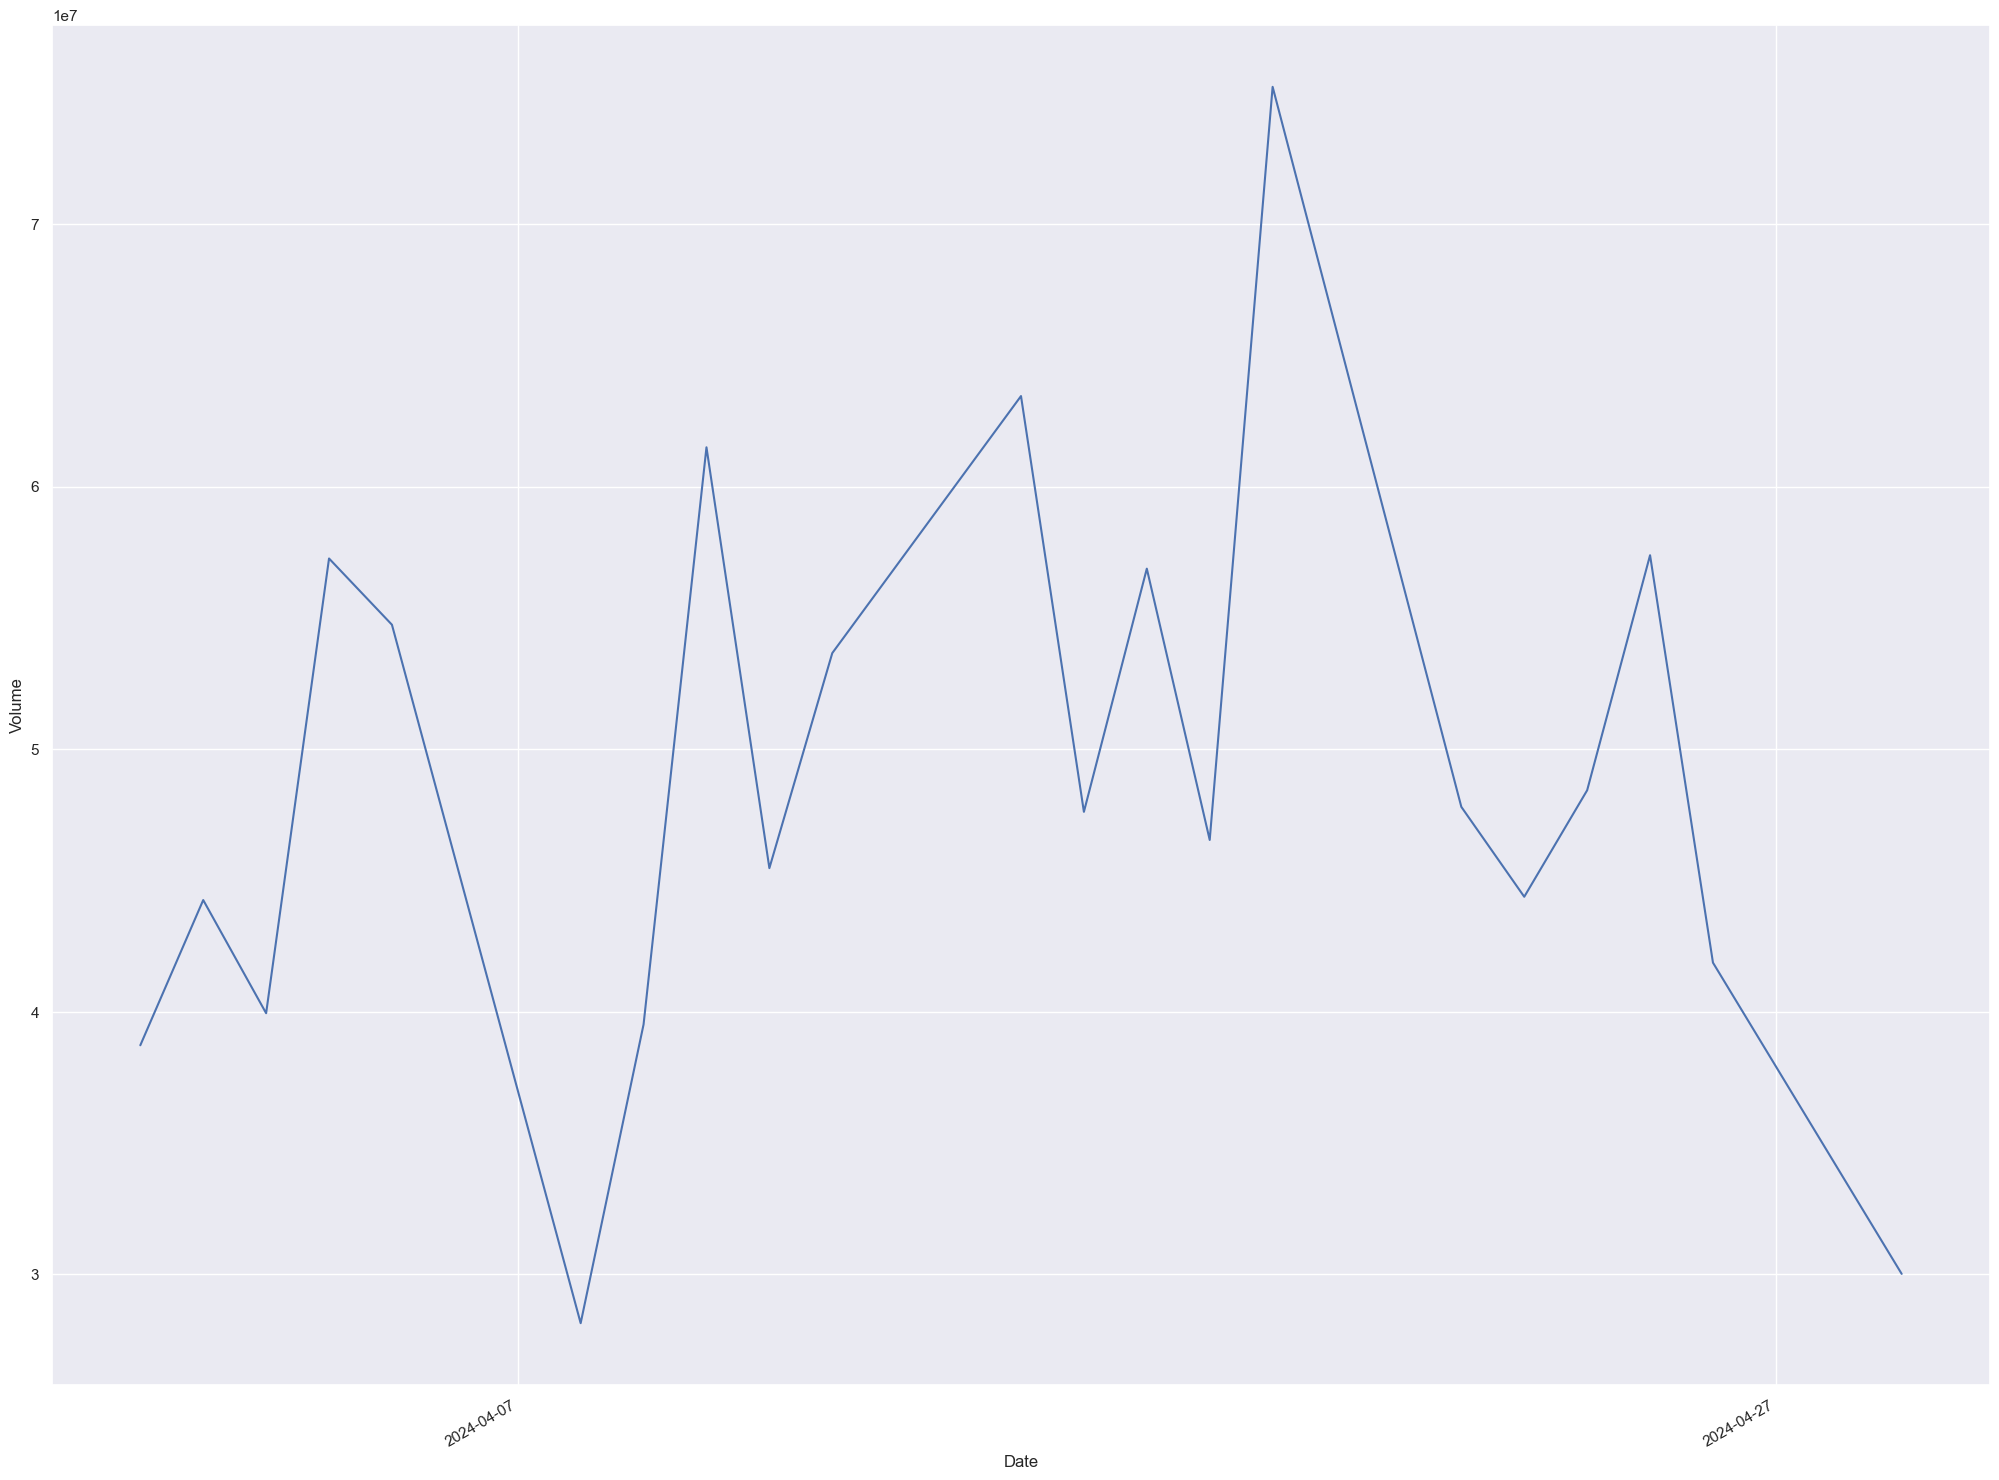

In [96]:
plot_time_series(df_price,'Volume')

## Backtesting


OPEN LONG position  |  2024-04-16 00:00:00  open operation price : 431.1
CLOSE LONG position | equity: 13160000.0  at  2024-04-17 00:00:00  gain:  13150000.0 $  close operation price : 425.84

OPEN LONG position  |  2024-04-18 00:00:00  open operation price : 423.41
CLOSE LONG position | equity: 28833560000.0  at  2024-04-19 00:00:00  gain:  28820400000.0 $  close operation price : 414.65

OPEN LONG position  |  2024-04-22 00:00:00  open operation price : 418.82
CLOSE LONG position | equity: -45023603940000.65  at  2024-04-23 00:00:00  gain:  -45052437500000.65 $  close operation price : 425.07

OPEN LONG position  |  2024-04-25 00:00:00  open operation price : 424.45
CLOSE LONG position | equity: -45023603940000.65  at  2024-04-25 00:00:00  gain:  -0.0 $  close operation price : 424.45
[11, 13, 15, 18]
[12, 14, 16, 18]


/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_25366/2824148757.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['open_signal'].iloc[idx] = Close
/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_25366/2824148757.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close_signal'].iloc[idx] = Close
/var/folders/vg/bhspxhys62sg4rcnvltrbvx80000gn/T/ipykernel_25366/2824148757.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

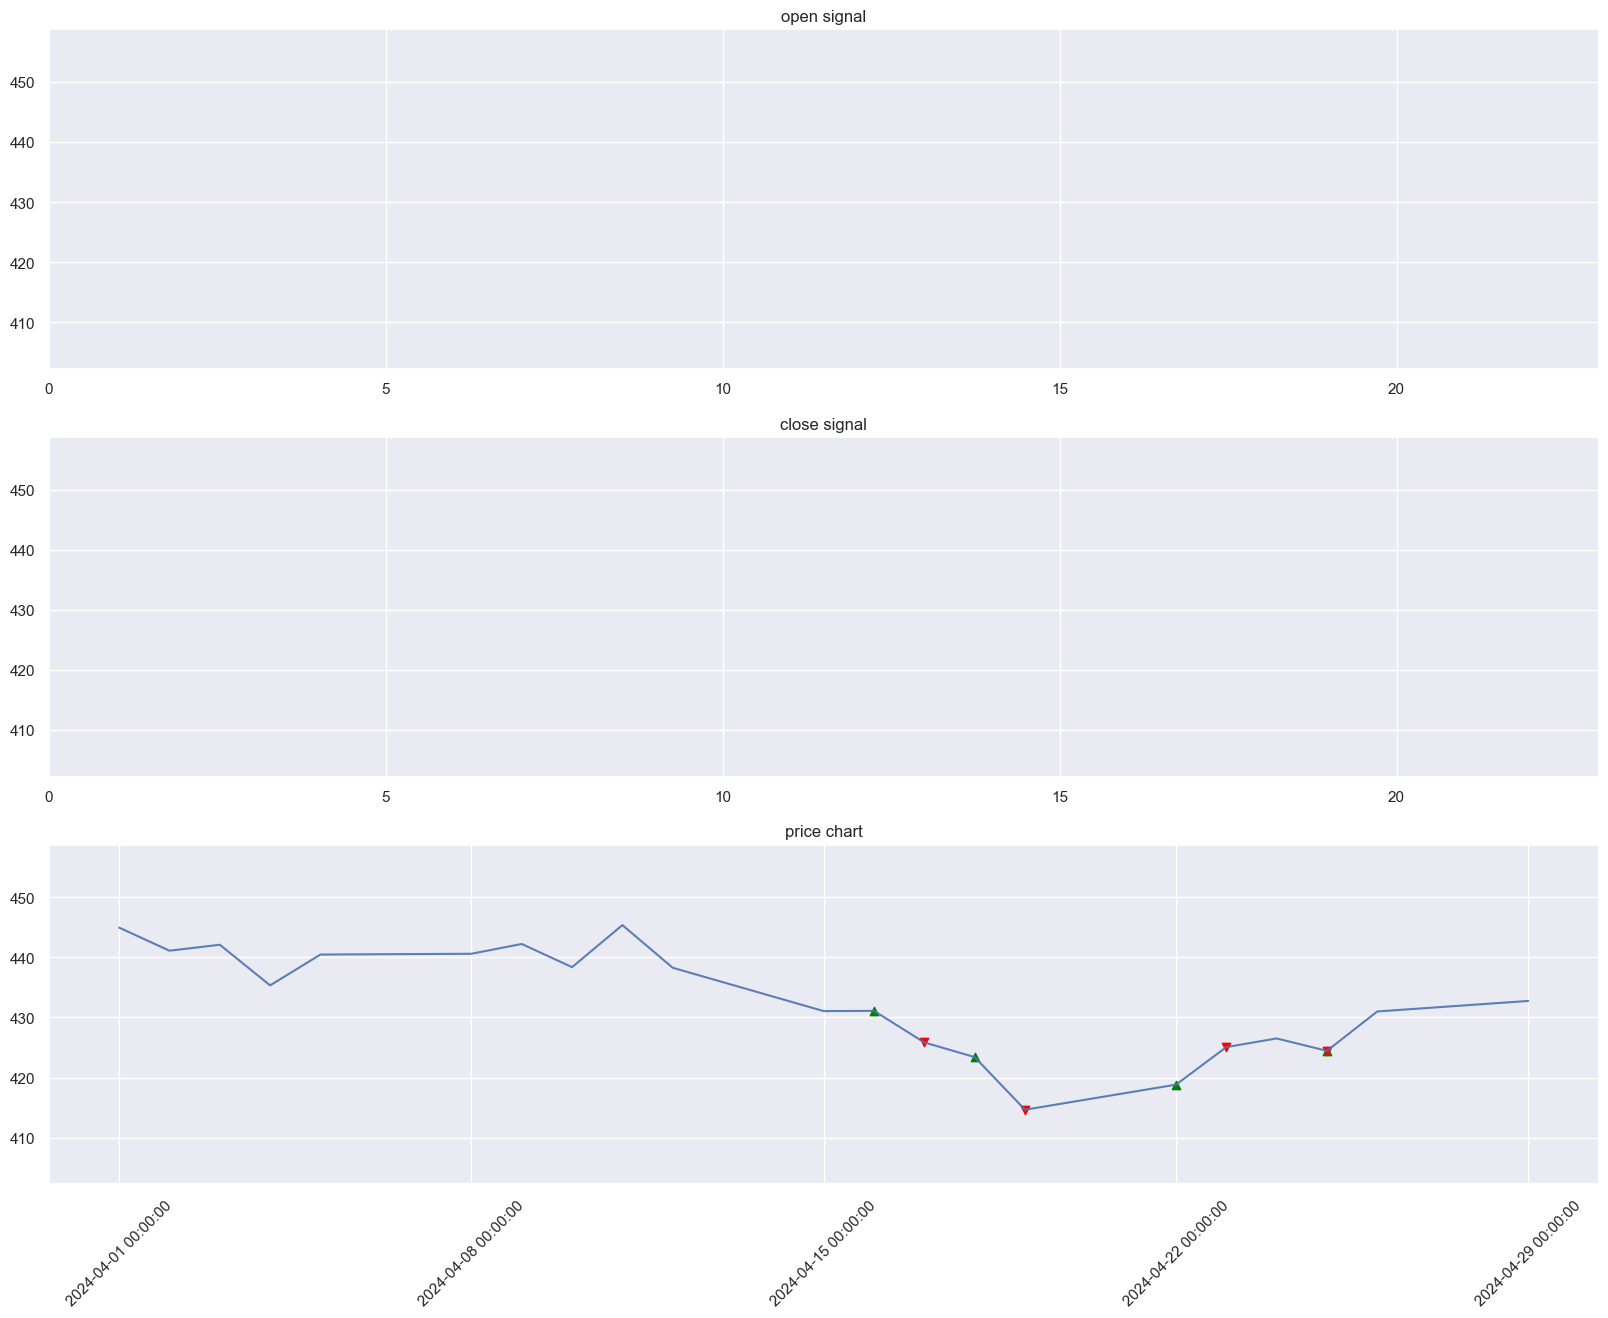

<Figure size 2500x2000 with 0 Axes>

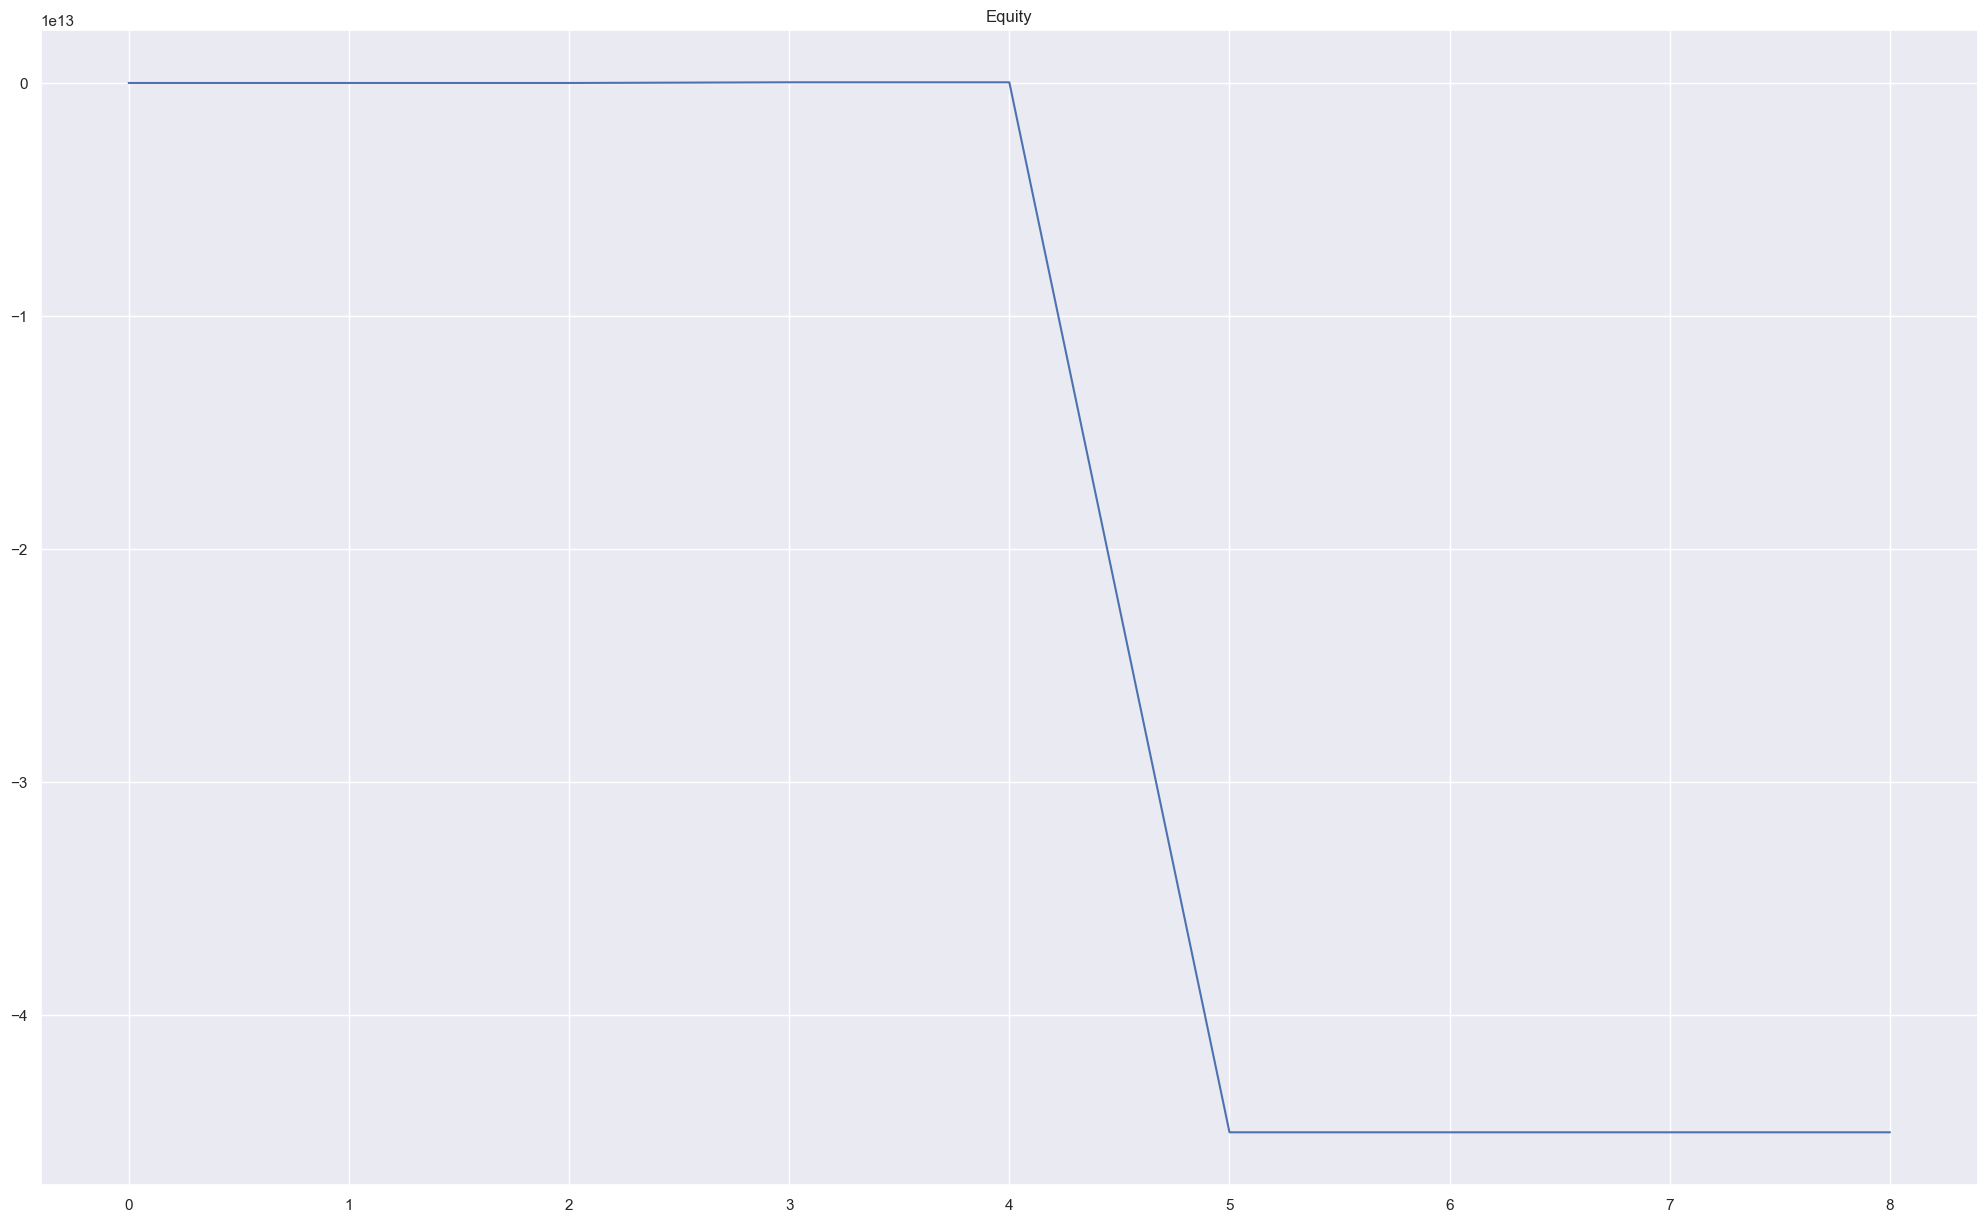

In [147]:
take_profit = 0.001 # % take profit
stop_loss = 0.0005 # % stop loss
cap = 10_000  # capital
laverage = 250 # laverage

def backtest(df, capital):
    initial_capital = capital
    plot_open_signal=[] # open signal
    plot_close_signal=[] # close signal
    equity_history=[]
    open_operation = False
    buffer_period=10
    df['open_signal'] = np.nan#pd.DataFrame(np.nan, index=range(len(df['close'])))#, columns=['A', 'B'])
    df['close_signal'] = np.nan
    
    for idx in range(len(df)):
        Date = df.index[idx]
        Open = df['Open'].iloc[idx]
        High = df['High'].iloc[idx]
        Low  = df['Low'].iloc[idx]
        Close  = df['Close'].iloc[idx]
        
        if int(idx) > buffer_period and int(idx) < len(df.values)-1:  # buffer
            
            if open_operation==False and Close < df['Close'].iloc[idx-2]:
                open_operation = True
                open_price = Close
                print('\nOPEN LONG position  | ',Date,' open operation price :',round(Close,8))
                plot_open_signal.append(idx)
                df['open_signal'].iloc[idx] = Close
                
            actual_price = Close
                                
            if open_operation==True: # LONG / BUY
                gain = (open_price - actual_price)*capital*laverage      
                real_TP = take_profit*capital
                real_SL = stop_loss*capital
                #print(gain,real_TP,real_SL)
                
                if (gain > real_TP or gain < -real_SL): # Close position 
                    capital += gain
                    open_operation = False
                    print('CLOSE LONG position | equity:', round(capital,2),' at ',Date, ' gain: ',round(gain,3),'$',' close operation price :',round(Close,10))
                    plot_close_signal.append(idx)
                    df['close_signal'].iloc[idx] = Close

            equity_history.append(capital)
    
    
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
    f.set_figheight(15)
    f.set_figwidth(20)

    print(plot_open_signal)
    print(plot_close_signal)
    
    # OPEN SIGNAL
    ax1.vlines(plot_open_signal,ymin=0,ymax=1,colors='green')
    ax1.set_title('open signal')

    ax1.set_ylim(0, 1)
    ax1.set_xlim(0,max(plot_open_signal)+5)
    x_axis1 = ax1.axes.get_xaxis()
    x_axis1.set_visible(True)
    y_axis1 = ax1.axes.get_yaxis()
    y_axis1.set_visible(True)
    
    
    # CLOSE SIGNAL
    ax2.vlines(plot_close_signal,ymin=0,ymax=1,colors='red')
    ax2.set_title('close signal')
    x_axis2 = ax2.axes.get_xaxis()    
    x_axis2.set_visible(True)
    y_axis2 = ax2.axes.get_yaxis()
    y_axis2.set_visible(True)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0,max(plot_open_signal)+5)

    
    # PRICES
    ax3.plot(df.index, df.Close,alpha=0.9)
    ax3.scatter(df.index,df['open_signal'], color='green', label='buy',marker='^',alpha=1 )
    ax3.scatter(df.index,df['close_signal'], color='red', label='sell' ,marker='v',alpha=1 )
    
    ax3.set_title('price chart')
    ax3.set_xticks(df.index[::5])
    ax3.set_xticklabels(df.index[::5], rotation=45)
    ax3.set_ylim(min(df.Close)*0.97, max(df.Close)*1.03)

    plt.figure(figsize=(25,20))
    plt.show()
    
    return equity_history                    


def plot_equity(equity_history):
    f, ax1 = plt.subplots(1, 1, sharey=True)
    f.set_figheight(15)
    #f.set_figwidth(20)
    plt.plot(equity_history)
    plt.title('Equity')
    plt.show()
    
equity = backtest(df_price, cap)
plot_equity(equity)